In [1]:

from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy
# Import neccessary modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding, Conv1D, MaxPooling1D, Flatten, BatchNormalization, GRU
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.metrics import Accuracy
# Note: Make sure module pdpipe is available.
# You might need to install it via
!pip install pdpipe
import pdpipe as pdp
%matplotlib inline
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report,accuracy_score,roc_curve,confusion_matrix

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.0/120.0 kB 5.3 MB/s eta 0:00:00
  Created wheel for decore: filename=decore-0.0.1-py2.py3-none-any.whl size=4188 sha256=f1bf0e238ce67a588563c0f43c18da1f998c5781df1bc8e145d332adc962e50d
  Stored in directory: /root/.cache/pip/wheels/66/5f/86/95d99f5eceb58f56ac3abfc8106165ce0337b00f66d28b32bc
Successfully built decore


/usr/local/lib/python3.11/dist-packages/pdpipe/col_generation.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
import warnings

warnings.filterwarnings("ignore")


def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    fxn()

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Set max width of cell
pd.options.display.max_colwidth=300

# Suppress scientific notation
np.set_printoptions(suppress=True)
pd.options.display.float_format = '{:.2f}'.format


# Display all columns
pd.set_option('display.max_columns', None)

# Read data
df_train = pd.read_csv("social_media_train.csv",index_col=[0])
display(df_train.head(),df_train.info())

<class 'pandas.core.frame.DataFrame'>
Index: 576 entries, 0 to 575
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   fake                   576 non-null    int64  
 1   profile_pic            576 non-null    object 
 2   ratio_numlen_username  576 non-null    float64
 3   len_fullname           576 non-null    int64  
 4   ratio_numlen_fullname  576 non-null    float64
 5   sim_name_username      576 non-null    object 
 6   len_desc               576 non-null    int64  
 7   extern_url             576 non-null    object 
 8   private                576 non-null    object 
 9   num_posts              576 non-null    int64  
 10  num_followers          576 non-null    int64  
 11  num_following          576 non-null    int64  
dtypes: float64(2), int64(6), object(4)
memory usage: 58.5+ KB


,fake,profile_pic,ratio_numlen_username,len_fullname,ratio_numlen_fullname,sim_name_username,len_desc,extern_url,private,num_posts,num_followers,num_following
0,0,Yes,0.27,0,0.00,No match,53,No,No,32,1000,955
1,0,Yes,0.00,2,0.00,Partial match,44,No,No,286,2740,533
2,0,Yes,0.10,2,0.00,Partial match,0,No,Yes,13,159,98
3,0,Yes,0.00,1,0.00,Partial match,82,No,No,679,414,651
4,0,Yes,0.00,2,0.00,No match,0,No,Yes,6,151,126


None

In [4]:
df_train['fake'].unique()

array([0, 1])

In [6]:
# Dataset Description
data_dict = pd.read_csv('fake_account__data_dict.csv', index_col = 'No.')
data_dict

,Column name,Data Type,Description
No.,,,
0,'profile_pic',categorical,Whether the account has a profile picture (1) or not (0)
1,'ratio_numlen_username',numerical (float),Ratio of numeric characters in the account username to its length
2,'len_fullname',numerical (int),Number of characters in the user's full name
3,'ratio_numlen_fullname',numerical (float),Ratio of numeric characters in the user's full name to its length
4,'sim_name_username',categorical,"Whether the user's name matches their username completely (1),not at all (0)."
5,'len_desc',numerical (int),Number of characters in the account description
6,'extern_url',categorical,Whether the account description includes a URL (1) or not (2)
7,'private',categorical,Whether the user's posts are visible only to their followers (1) or to all Instagram users (2).
8,'num_posts',numerical (int),Number of posts in the user account


In [7]:
# Determine categorical and numerical features

# Numerical columns
num_cols = ['ratio_numlen_username','len_fullname','ratio_numlen_fullname',
            'len_desc','num_posts','num_followers',
              'num_following']
# Categorical columns
cat_cols = [col for col in df_train.columns.values.tolist() if col not in num_cols]
cat_cols

['fake', 'profile_pic', 'sim_name_username', 'extern_url', 'private']

In [8]:
# Check descriptive statistics
df_train[num_cols].describe()

,ratio_numlen_username,len_fullname,ratio_numlen_fullname,len_desc,num_posts,num_followers,num_following
count,576.00,576.00,576.00,576.00,576.00,576.00,576.00
mean,0.16,1.46,0.04,22.62,107.49,85307.24,508.38
std,0.21,1.05,0.13,37.70,402.03,910148.46,917.98
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,1.00,0.00,0.00,0.00,39.00,57.50
50%,0.00,1.00,0.00,0.00,9.00,150.50,229.50
75%,0.31,2.00,0.00,34.00,81.50,716.00,589.50
max,0.92,12.00,1.00,150.00,7389.00,15338538.00,7500.00


In [9]:
df_train.isnull().sum()

,0
fake,0
profile_pic,0
ratio_numlen_username,0
len_fullname,0
ratio_numlen_fullname,0
sim_name_username,0
len_desc,0
extern_url,0
private,0
num_posts,0


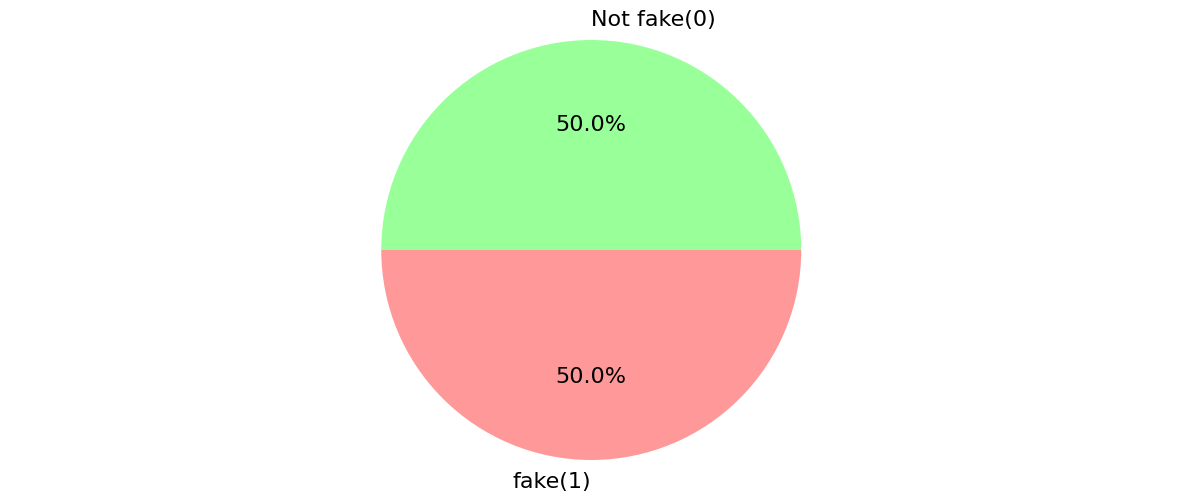

In [10]:
# Get an idea of target category share: fake
plt.figure(figsize=(15,6))
fake_share = df_train["fake"].value_counts()
mylabel=["Not fake(0)","fake(1)"]
colors = ['#99ff99','#ff9999']
plt.pie(fake_share,
        labels=mylabel,autopct="%1.1f%%",colors=colors,
        textprops={'fontsize': 16})
plt.axis("equal");

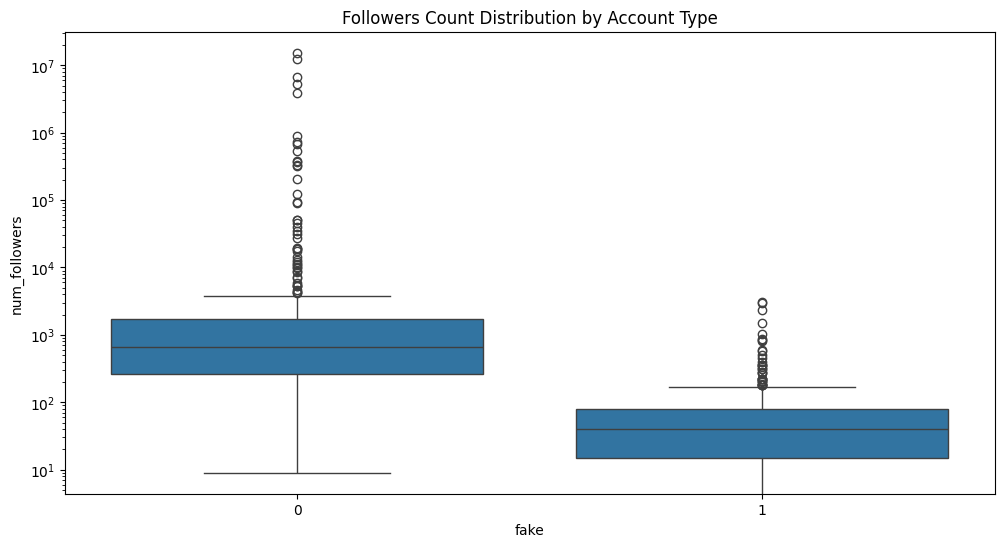

In [11]:
plt.figure(figsize=(12,6))
sns.boxplot(x='fake', y='num_followers', data=df_train)
plt.yscale('log')
plt.title('Followers Count Distribution by Account Type')
plt.show()

In [ ]:
# Additional plots with Plotly
import seaborn as sns
import plotly.express as px
fig = px.histogram(df_train, x="num_followers", color="fake", marginal="box", nbins=50, title="Followers Distribution")
fig.show()

In [ ]:

fig = px.scatter(df_train, x="num_following", y="num_followers", color="fake", title="Following vs Followers")
fig.show()

In [ ]:
corr = df_train[num_cols].corr()
corr.style.background_gradient(cmap='coolwarm')

,ratio_numlen_username,len_fullname,ratio_numlen_fullname,len_desc,num_posts,num_followers,num_following
ratio_numlen_username,1.000000,-0.225472,0.408567,-0.321170,-0.157442,-0.062785,-0.172413
len_fullname,-0.225472,1.000000,-0.094348,0.272522,0.073350,0.033225,0.094855
ratio_numlen_fullname,0.408567,-0.094348,1.000000,-0.117521,-0.057716,-0.027035,-0.067971
len_desc,-0.321170,0.272522,-0.117521,1.000000,0.144824,0.005929,0.226561
num_posts,-0.157442,0.073350,-0.057716,0.144824,1.000000,0.321385,0.098225
num_followers,-0.062785,0.033225,-0.027035,0.005929,0.321385,1.000000,-0.011066
num_following,-0.172413,0.094855,-0.067971,0.226561,0.098225,-0.011066,1.000000


Text(0.5, 0.98, 'Pair Plot of Characteristics')

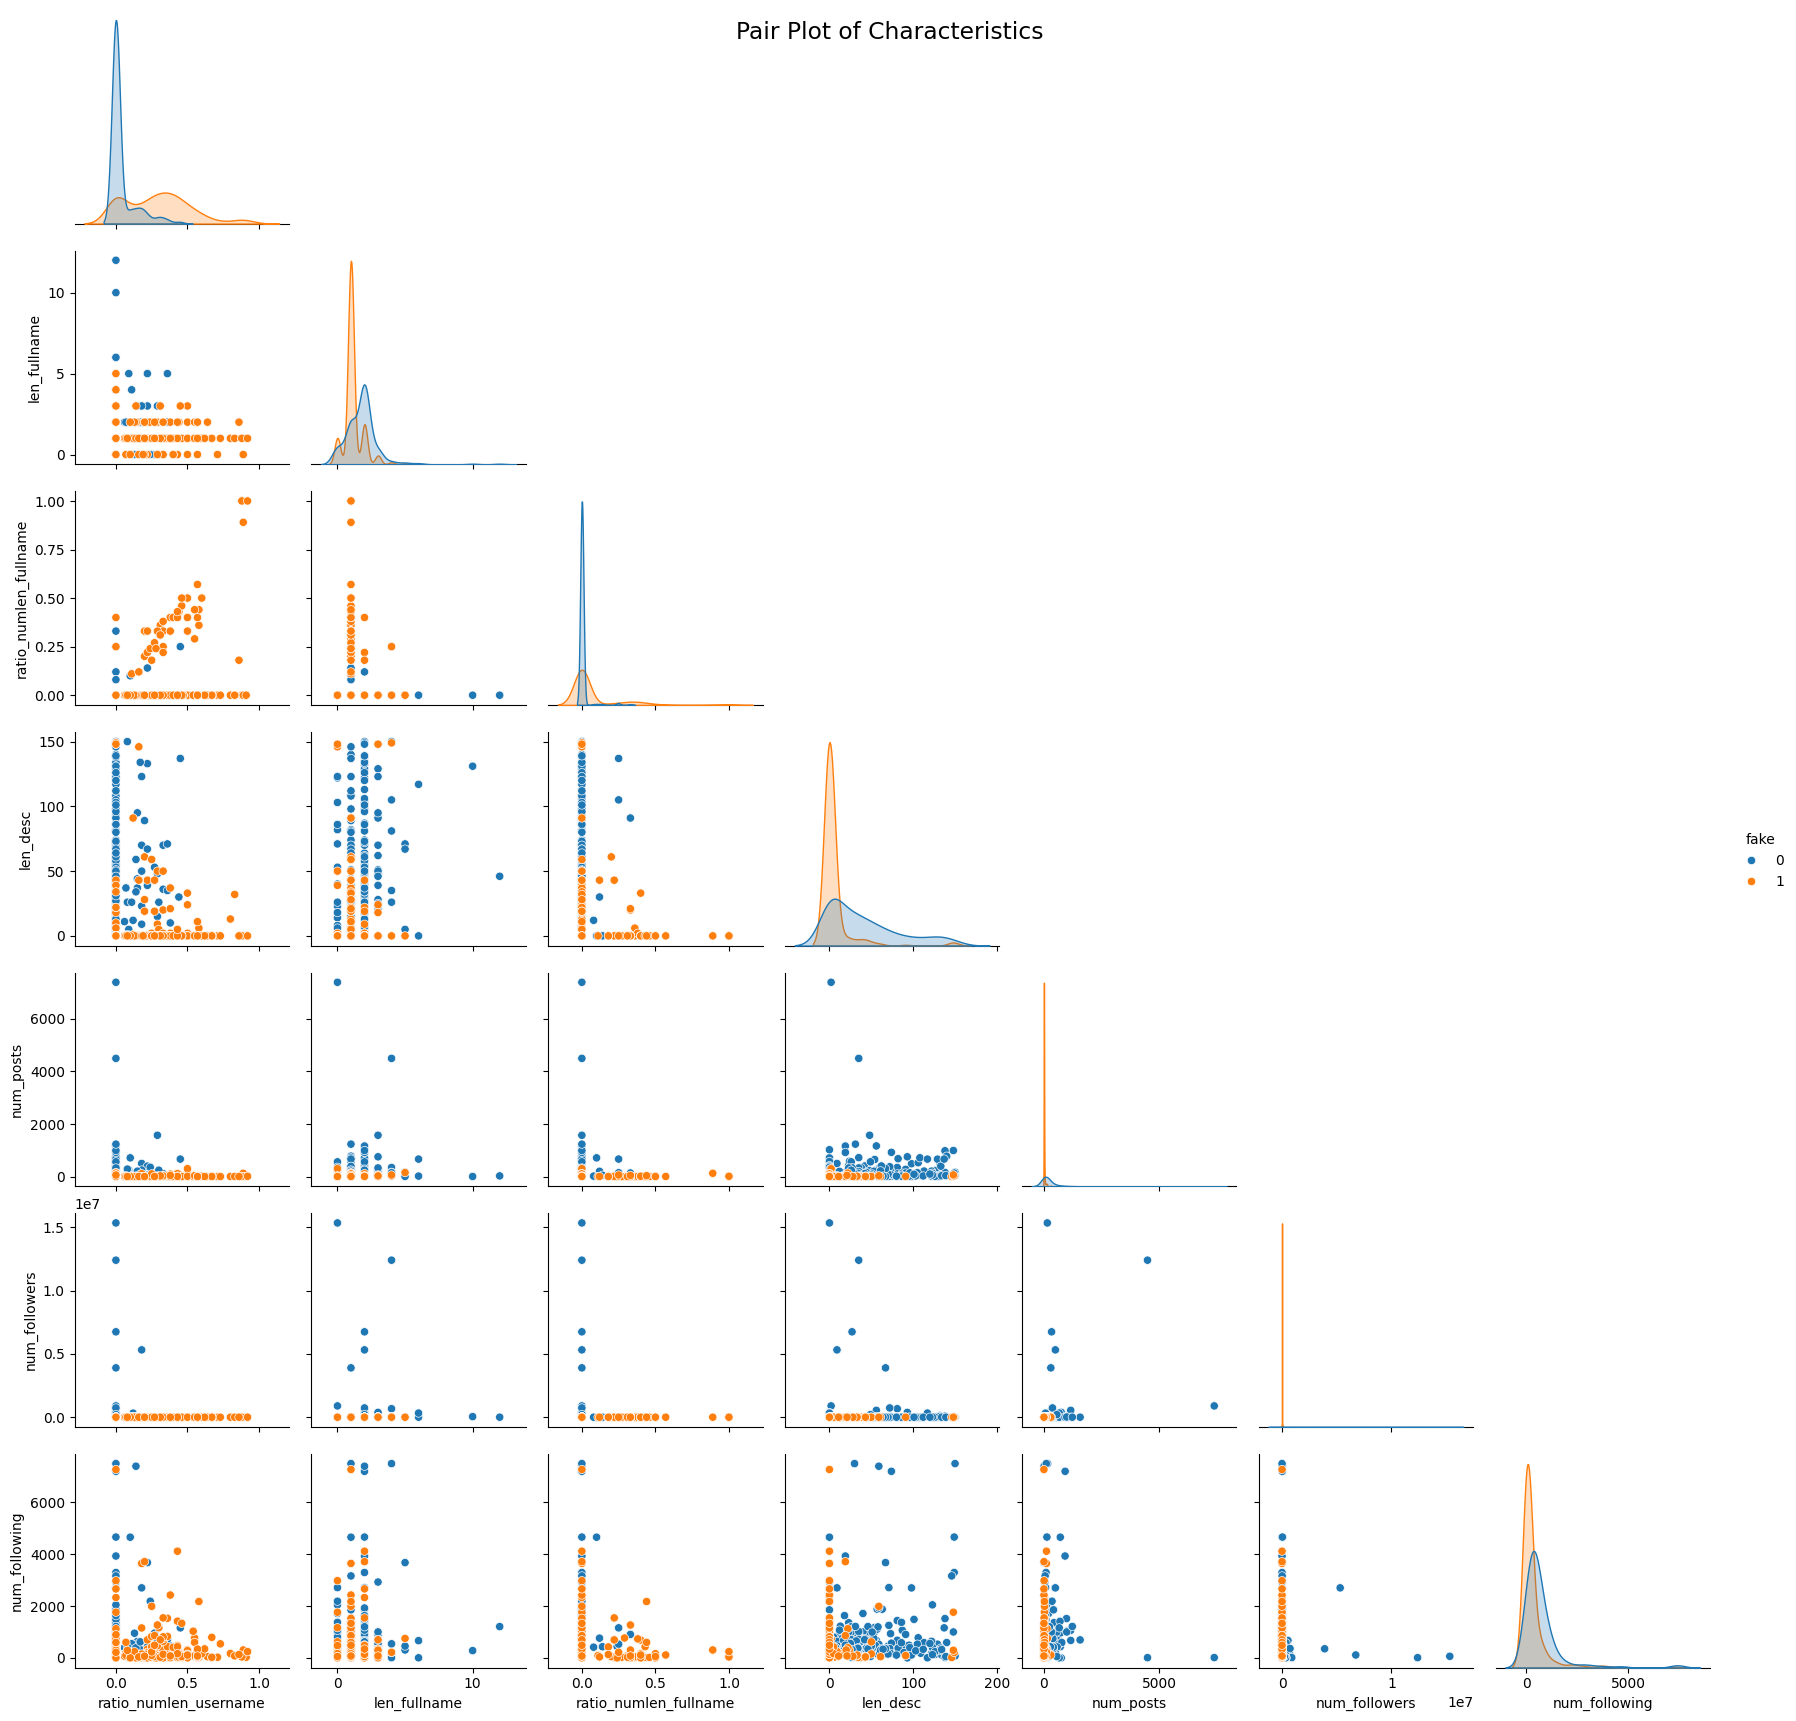

In [ ]:
# Pair plot oapif numerical values with fake account information
pp_cols = []
pp_cols = num_cols + ['fake']
ax=sns.pairplot(df_train[pp_cols], hue="fake",corner=True);
plt.style.use('fivethirtyeight')
ax.fig.suptitle("Pair Plot of Characteristics")

In [12]:
# Categorical data
display(df_train.loc[:, cat_cols].head())
print('----------------------')

# Unique values
for col in cat_cols:
    unique_values = df_train.loc[:, col].unique()
    print("\nColumn name: {}\nUnique values: {}".format(col, unique_values))

,fake,profile_pic,sim_name_username,extern_url,private
0,0,Yes,No match,No,No
1,0,Yes,Partial match,No,No
2,0,Yes,Partial match,No,Yes
3,0,Yes,Partial match,No,No
4,0,Yes,No match,No,Yes


----------------------

Column name: fake
Unique values: [0 1]

Column name: profile_pic
Unique values: ['Yes' 'No']

Column name: sim_name_username
Unique values: ['No match' 'Partial match' 'Full match']

Column name: extern_url
Unique values: ['No' 'Yes']

Column name: private
Unique values: ['No' 'Yes']


In [13]:
# Define function label_encoding
def label_encoding(df):
    '''
    Function label_encoding() transforms categorical features
    represented by strings to binary features containing only
    0s and 1s which can be used for machine learning models.
    Input:
        DataFrame of features
    Output:
        New DataFrame with binary features
    '''
    # Label encoding for columns with Yes/No or True/False
    dict_label_encoding = {'Yes': 1, 'No': 0, True: 1, False: 0}  # Updated to handle True/False
    df.loc[:, 'profile_pic'] = df.loc[:, 'profile_pic'].replace(dict_label_encoding)
    df.loc[:, 'extern_url'] = df.loc[:, 'extern_url'].replace(dict_label_encoding)
    df.loc[:, 'private'] = df.loc[:, 'private'].replace(dict_label_encoding)

    # One-hot encoding
    # Assuming pdp.OneHotEncode is a typo or custom; using pd.get_dummies instead for clarity
    df = pd.get_dummies(df, columns=["sim_name_username"], prefix="sim_name_username", drop_first=False)

    # Convert True/False to 1/0 in the one-hot encoded columns
    for col in df.columns:
        if df[col].dtype == bool:  # Check if column is boolean
            df[col] = df[col].astype(int)  # Convert True/False to 1/0

    return df

# Apply function label_encoding
df_train_new = label_encoding(df_train)
df_train_new.head()

,fake,profile_pic,ratio_numlen_username,len_fullname,ratio_numlen_fullname,len_desc,extern_url,private,num_posts,num_followers,num_following,sim_name_username_Full match,sim_name_username_No match,sim_name_username_Partial match
0,0,1,0.27,0,0.00,53,0,0,32,1000,955,0,1,0
1,0,1,0.00,2,0.00,44,0,0,286,2740,533,0,0,1
2,0,1,0.10,2,0.00,0,0,1,13,159,98,0,0,1
3,0,1,0.00,1,0.00,82,0,0,679,414,651,0,0,1
4,0,1,0.00,2,0.00,0,0,1,6,151,126,0,1,0


In [14]:
# Import Logistic Regression model
from sklearn.linear_model import LogisticRegression

###################################################################
# a) Without regularisation

# Feature matrix and target vector
features_train = df_train_new.iloc[:, 1:]
target_train = df_train_new.loc[:, 'fake']

# Model instantiation
model_log = LogisticRegression(solver='lbfgs', C=1e42, random_state=42)

# Model fitting
model_log.fit(features_train, target_train)

#####################################################################
# b) With regularisation

# Standardization to adjust the features
from sklearn.preprocessing import StandardScaler

# Fit on training data and scale them
scaler = StandardScaler()
features_train_scaled = scaler.fit_transform(features_train)

# Model instantiation
model_reg = LogisticRegression(solver='lbfgs', max_iter=10000, C=0.5, random_state=42)
# Changed max_iter=1e4 to max_iter=10000

# Model fitting
model_reg.fit(features_train_scaled, target_train)

LogisticRegression(C=0.5, max_iter=10000, random_state=42)

In [15]:
# Read data
df_test = pd.read_csv("social_media_test.csv",index_col=[0])
df_test_new = label_encoding(df_test)
df_test_new.head()

,fake,profile_pic,ratio_numlen_username,len_fullname,ratio_numlen_fullname,len_desc,extern_url,private,num_posts,num_followers,num_following,sim_name_username_Full match,sim_name_username_No match,sim_name_username_Partial match
0,0,1,0.33,1,0.33,30,0,1,35,488.00,604,1,0,0
1,0,1,0.00,5,0.00,64,0,1,3,35.00,6,0,0,1
2,0,1,0.00,2,0.00,82,0,1,319,328.00,668,0,0,1
3,0,1,0.00,1,0.00,143,0,1,273,14890.00,7369,0,1,0
4,0,1,0.50,1,0.00,76,0,1,6,225.00,356,0,1,0


In [16]:
# Feature matrix and target vector
features_test = df_test_new.drop('fake',axis=1)
target_test = df_test_new['fake']

 # Without regularisation
# predict target values from model
target_test_pred_log = model_log.predict(features_test)

# model evaluation
from sklearn.metrics import precision_score, recall_score
precision_log = precision_score(target_test, target_test_pred_log)
recall_log = recall_score(target_test, target_test_pred_log)

# print
print('Precision of model without regularisation: ', precision_log)
print('Recall of model without regularisation: ', recall_log)

#####################################################################
# With regularisation
# features matrix and target vector
features_test_scaled = scaler.transform(features_test)

# predict target values from model
target_test_pred_reg = model_reg.predict(features_test_scaled)

# model evaluation
precision_reg = precision_score(target_test, target_test_pred_reg)
recall_reg = recall_score(target_test, target_test_pred_reg)

# print
print('Precision of model with regularisation: ', precision_reg)
print('Recall of model with regularisation: ', recall_reg)

Precision of model without regularisation:  0.875
Recall of model without regularisation:  0.9333333333333333
Precision of model with regularisation:  0.8813559322033898
Recall of model with regularisation:  0.8666666666666667


In [17]:
# module import
from sklearn.metrics import roc_curve

# calculate roc curve values
def roc_curve_values(model, features, target):
    '''
    Function roc_curve_values estimates the probability
    and return roc_curve values as output.

    Input:
        model, features as dataframe, target values
    Output:
        False positive rate, recall, target_test_pred_proba
    '''
    # calculate probability
    target_test_pred_proba = model.predict_proba(features)

    # calculate roc curve values
    false_positive_rate, recall, threshold = roc_curve(target,
                                                       target_test_pred_proba[:,1],
                                                       drop_intermediate=False)

    return false_positive_rate, recall, target_test_pred_proba  # Fixed typo here

In [18]:
# Apply function roc_curve_values for model without regularization
false_positive_rate_log, recall_log, target_test_pred_proba_log = roc_curve_values(model_log, features_test, target_test)

In [19]:
# Apply function roc_curve_values for model with regularization
false_positive_rate_reg, recall_reg, target_test_pred_proba_reg = roc_curve_values(model_reg, features_test_scaled, target_test)

In [20]:
def roc_curve_plot(false_positive_rate,recall,label):
    '''
    Function roc_curve_plot plots ROC
    Input:
        false_positive_rate, recall, label: model type
    Output:
        ROC plot
    '''
    plt.style.use('fivethirtyeight')
    fig,ax=plt.subplots()

    # Reference lines
    # Blue diagonal
    ax.plot([0, 1], ls = "--", label='random model')
    # Grey vertical
    ax.plot([0, 0], [1, 0], c=".7", ls='--', label='ideal model')
    # Grey horizontal
    ax.plot([1, 1], c=".7", ls='--')

    # ROC curve
    ax.plot(false_positive_rate,recall, label = label)

    # labels
    ax.set_title("Receiver Operating Characteristic")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("Recall")
    ax.legend()

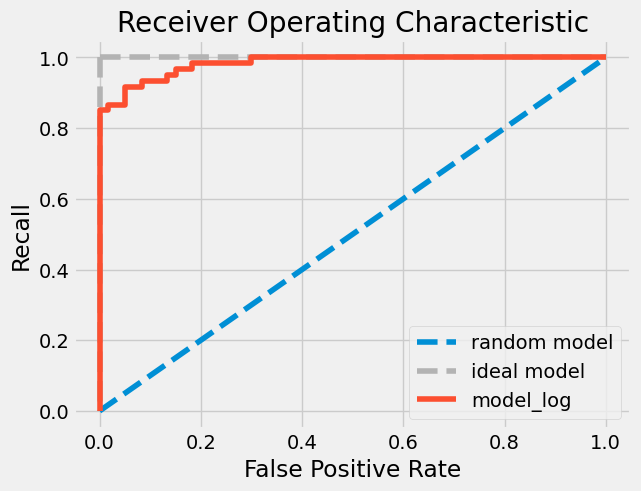

In [ ]:
roc_curve_plot(false_positive_rate_log,recall_log,'model_log')

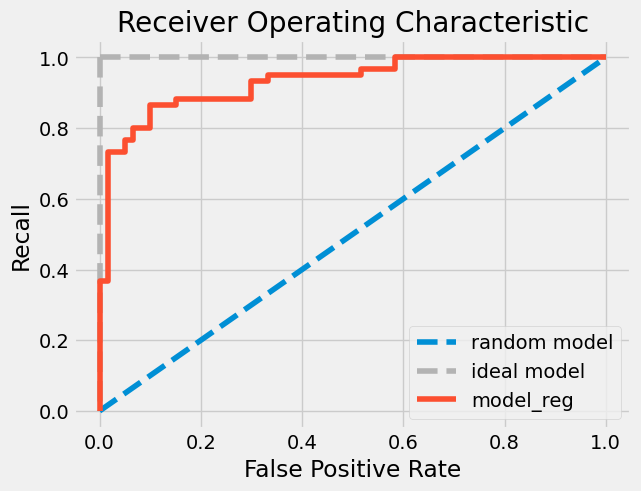

In [21]:
roc_curve_plot(false_positive_rate_reg,recall_reg,'model_reg')

In [22]:
# Import roc_auc_score
from sklearn.metrics import roc_auc_score
print('roc_auc_score for model without regularization', roc_auc_score(target_test, target_test_pred_proba_log[:, 1]))
print('##########################################################')
print('roc_auc_score for model with regularization', roc_auc_score(target_test, target_test_pred_proba_reg[:, 1]))

roc_auc_score for model without regularization 0.9830555555555556
##########################################################
roc_auc_score for model with regularization 0.9322222222222222


# IMPLEMENTATION OF LSTM AND GRU

In [23]:
df = df_train_new.copy()

In [24]:
# Splitting Data
X = df.drop(columns=['fake'])
y = df['fake']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
X_train = np.array(X_train, dtype=np.float32).reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = np.array(X_test, dtype=np.float32).reshape((X_test.shape[0], X_test.shape[1], 1))
y_train = np.array(y_train, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

In [26]:
# Building Complex LSTM Model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.3),
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    LSTM(32),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 13, 128)             │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 13, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 13, 64)              │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 13, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 128,929 (503.63 KB)

 Trainable params: 128,929 (503.63 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Training the Model
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - accuracy: 0.6844 - loss: 0.6654 - val_accuracy: 0.7414 - val_loss: 0.5878
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.8052 - loss: 0.5242 - val_accuracy: 0.7328 - val_loss: 0.5163
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.8323 - loss: 0.4084 - val_accuracy: 0.7500 - val_loss: 0.5071
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.8722 - loss: 0.3656 - val_accuracy: 0.8448 - val_loss: 0.3907
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.8556 - loss: 0.3554 - val_accuracy: 0.8621 - val_loss: 0.3866
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.8652 - loss: 0.3479 - val_accuracy: 0.8621 - val_loss: 0.3722
Epoch 7/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.8911 - loss: 0.3040 - val_accuracy: 0.8793 - val_loss: 0.3674
Epoch 8/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.8961 - loss: 0.2774 - val_accuracy: 0.8362 - v

In [28]:
# Building an Advanced GRU-based Model
model_gru = Sequential([
    GRU(128, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.3),
    GRU(64, return_sequences=True),
    Dropout(0.3),
    GRU(32),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

In [29]:
model_gru.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_gru.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 13, 128)             │          50,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 13, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 13, 64)              │          37,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 13, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_2 (GRU)                          │ (None, 32)                  │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 97,505 (380.88 KB)

 Trainable params: 97,505 (380.88 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
history_gru = model_gru.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 93ms/step - accuracy: 0.5993 - loss: 0.6469 - val_accuracy: 0.7414 - val_loss: 0.5350
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.8061 - loss: 0.4856 - val_accuracy: 0.7845 - val_loss: 0.4947
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.8430 - loss: 0.4108 - val_accuracy: 0.7672 - val_loss: 0.4830
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.8386 - loss: 0.3938 - val_accuracy: 0.8362 - val_loss: 0.4133
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.8615 - loss: 0.3513 - val_accuracy: 0.8707 - val_loss: 0.3807
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.8849 - loss: 0.2940 - val_accuracy: 0.8707 - val_loss: 0.3835
Epoch 7/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.8536 - loss: 0.3543 - val_accuracy: 0.8621 - val_loss: 0.3801
Epoch 8/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.8837 - loss: 0.3036 - val_accuracy: 0.7931 - v

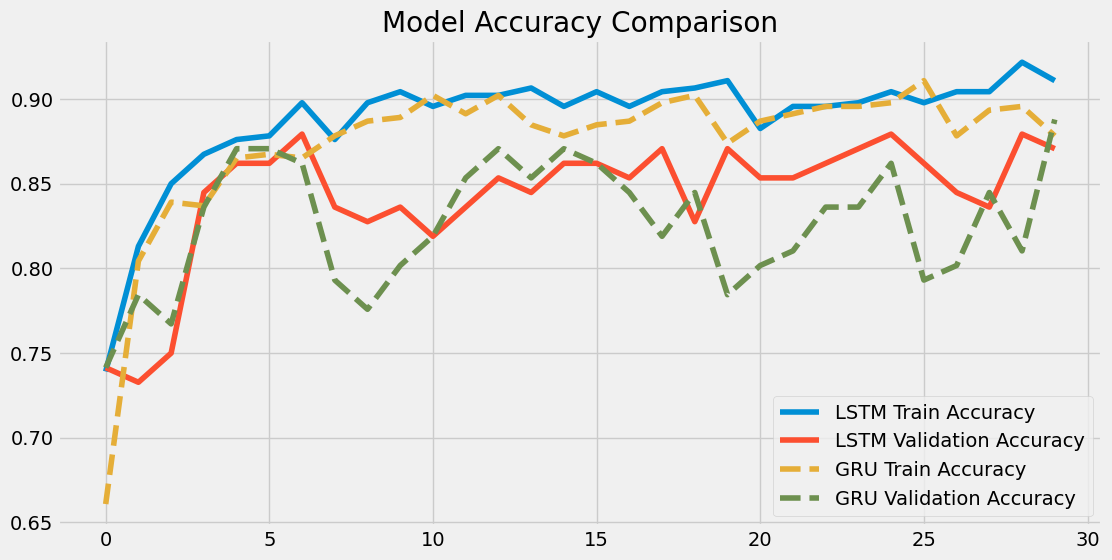

In [31]:
# Model Evaluation
plt.figure(figsize=(12,6))
plt.plot(history.history['accuracy'], label='LSTM Train Accuracy')
plt.plot(history.history['val_accuracy'], label='LSTM Validation Accuracy')
plt.plot(history_gru.history['accuracy'], label='GRU Train Accuracy', linestyle='dashed')
plt.plot(history_gru.history['val_accuracy'], label='GRU Validation Accuracy', linestyle='dashed')
plt.title('Model Accuracy Comparison')
plt.legend()
plt.show()

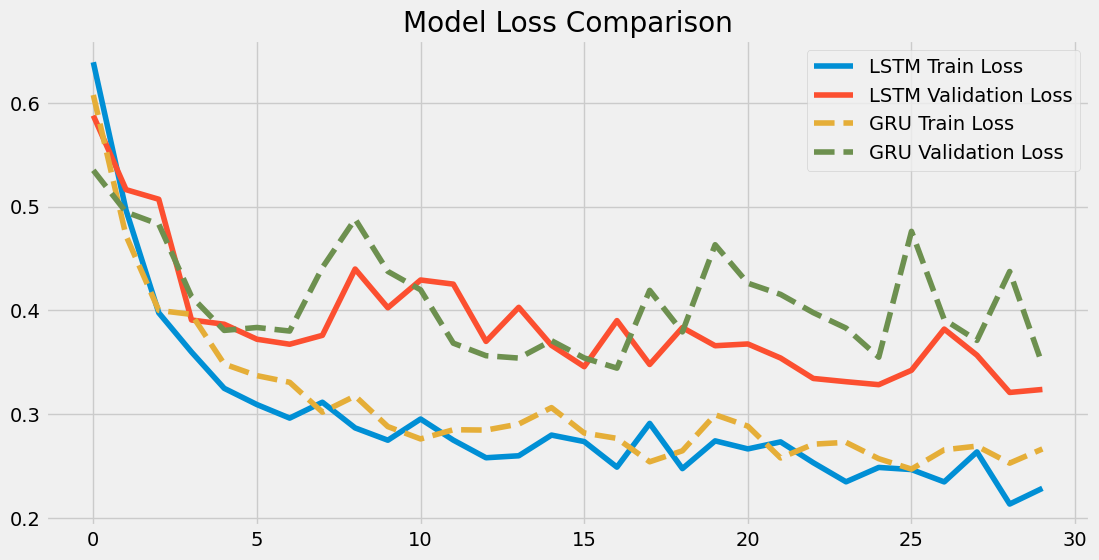

In [32]:
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], label='LSTM Train Loss')
plt.plot(history.history['val_loss'], label='LSTM Validation Loss')
plt.plot(history_gru.history['loss'], label='GRU Train Loss', linestyle='dashed')
plt.plot(history_gru.history['val_loss'], label='GRU Validation Loss', linestyle='dashed')
plt.title('Model Loss Comparison')
plt.legend()
plt.show()

In [33]:
# Predicting and evaluating performance
y_pred_lstm = (model.predict(X_test) > 0.5).astype('int')
y_pred_gru = (model_gru.predict(X_test) > 0.5).astype('int')
from sklearn.metrics import classification_report, confusion_matrix
print("LSTM Model Performance:")
print(classification_report(y_test, y_pred_lstm))
print(confusion_matrix(y_test, y_pred_lstm))

print("GRU Model Performance:")
print(classification_report(y_test, y_pred_gru))
print(confusion_matrix(y_test, y_pred_gru))


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step
LSTM Model Performance:
              precision    recall  f1-score   support

         0.0       0.83      0.95      0.89        63
         1.0       0.93      0.77      0.85        53

    accuracy                           0.87       116
   macro avg       0.88      0.86      0.87       116
weighted avg       0.88      0.87      0.87       116

[[60  3]
 [12 41]]
GRU Model Performance:
              precision    recall  f1-score   support

         0.0       0.89      0.90      0.90        63
         1.0       0.88      0.87      0.88        53

    accuracy                           0.89       116
   macro avg       0.89      0.89      0.89       116
weighted avg       0.89      0.89      0.89       116

[[57  6]
 [ 7 46]]


# *Building High-Complex Deep Learning Model*

In [34]:
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding, Conv1D, MaxPooling1D, Flatten, BatchNormalization, GRU, Bidirectional, Attention

model_complex = Sequential([
    Bidirectional(LSTM(256, return_sequences=True, activation='tanh'), input_shape=(X_train.shape[1], 1)),
    Dropout(0.3),
    Bidirectional(GRU(128, return_sequences=True, activation='tanh')),
    Dropout(0.3),
    Conv1D(128, kernel_size=3, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Bidirectional(LSTM(64, return_sequences=True, activation='tanh')),
    Dropout(0.3),
    Bidirectional(GRU(32, return_sequences=False, activation='tanh')),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [35]:

model_complex.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_complex.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 13, 512)             │         528,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 13, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 13, 256)             │         493,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 13, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 13, 128)             │          98,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 13, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 6, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 6, 128)              │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 6, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 64)                  │          31,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,256,577 (4.79 MB)

 Trainable params: 1,256,321 (4.79 MB)

 Non-trainable params: 256 (1.00 KB)

In [36]:
# Training the Complex Model
history_complex = model_complex.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 21s 273ms/step - accuracy: 0.7791 - loss: 0.5204 - val_accuracy: 0.6638 - val_loss: 0.9511
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step - accuracy: 0.9045 - loss: 0.2644 - val_accuracy: 0.6121 - val_loss: 1.1752
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 237ms/step - accuracy: 0.9024 - loss: 0.2978 - val_accuracy: 0.7845 - val_loss: 0.5057
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 171ms/step - accuracy: 0.8883 - loss: 0.3133 - val_accuracy: 0.7500 - val_loss: 0.7384
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step - accuracy: 0.8592 - loss: 0.3302 - val_accuracy: 0.7672 - val_loss: 0.5918
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - accuracy: 0.8883 - loss: 0.2937 - val_accuracy: 0.7845 - val_loss: 0.5681
Epoch 7/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 185ms/step - accuracy: 0.8956 - loss: 0.2599 - val_accuracy: 0.6552 - val_loss: 0.6900
Epoch 8/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 159ms/step - accuracy: 0.9190 - loss: 0.2145 - val_accuracy: 0

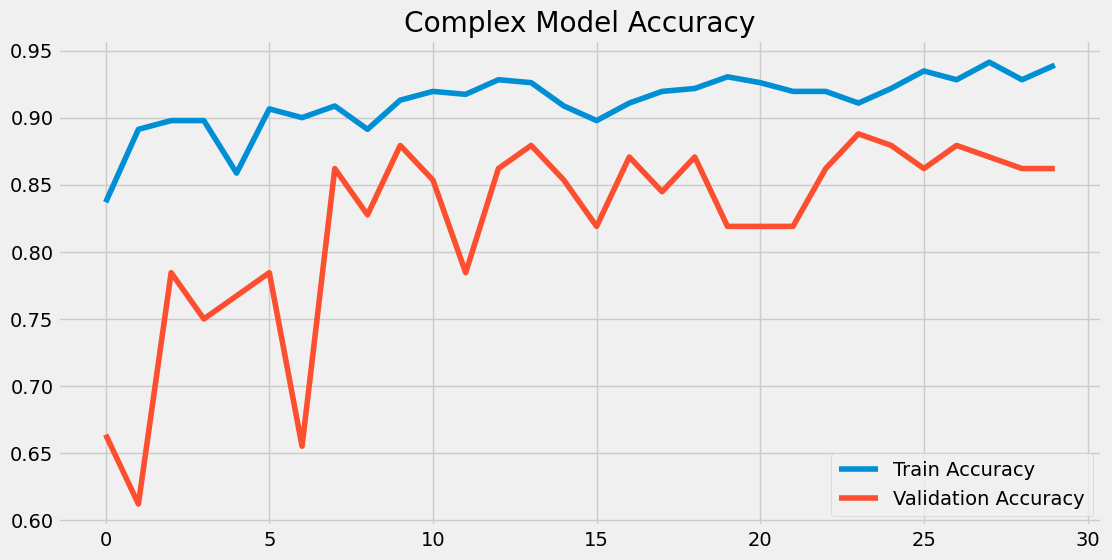

In [37]:
# Model Evaluation
plt.figure(figsize=(12,6))
plt.plot(history_complex.history['accuracy'], label='Train Accuracy')
plt.plot(history_complex.history['val_accuracy'], label='Validation Accuracy')
plt.title('Complex Model Accuracy')
plt.legend()
plt.show()




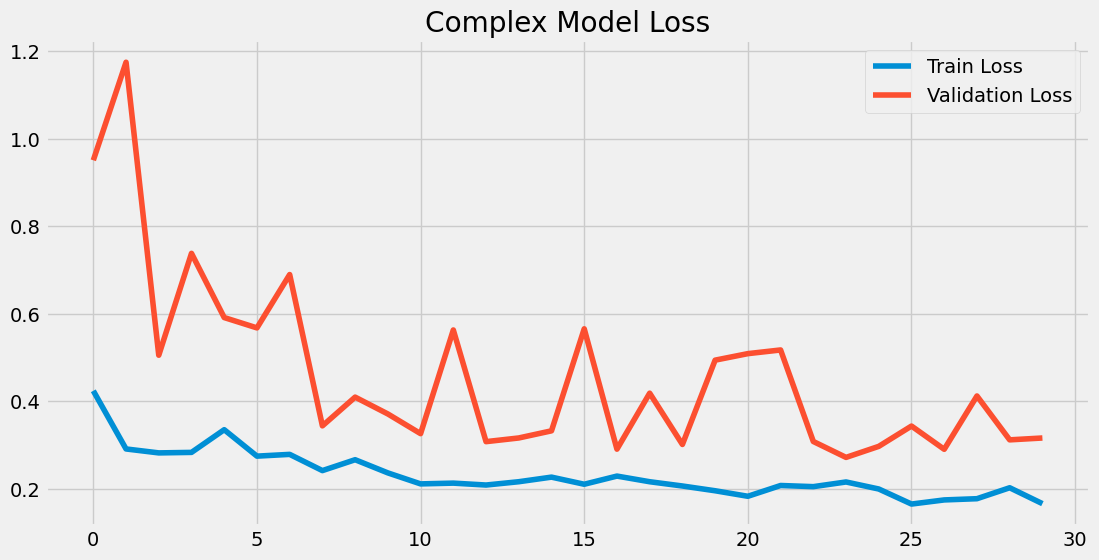

In [38]:
plt.figure(figsize=(12,6))
plt.plot(history_complex.history['loss'], label='Train Loss')
plt.plot(history_complex.history['val_loss'], label='Validation Loss')
plt.title('Complex Model Loss')
plt.legend()
plt.show()

In [39]:
# Predicting and evaluating performance
y_pred_complex = (model_complex.predict(X_test) > 0.5).astype('int')
from sklearn.metrics import classification_report, confusion_matrix
print("Complex Model Performance:")
print(classification_report(y_test, y_pred_complex))
print(confusion_matrix(y_test, y_pred_complex))


3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 690ms/step
Complex Model Performance:
              precision    recall  f1-score   support

         0.0       0.87      0.87      0.87        63
         1.0       0.85      0.85      0.85        53

    accuracy                           0.86       116
   macro avg       0.86      0.86      0.86       116
weighted avg       0.86      0.86      0.86       116

[[55  8]
 [ 8 45]]


In [41]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.1/322.1 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 90.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 5.0 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
tor

In [43]:
df_train_new.head()

,fake,profile_pic,ratio_numlen_username,len_fullname,ratio_numlen_fullname,len_desc,extern_url,private,num_posts,num_followers,num_following,sim_name_username_Full match,sim_name_username_No match,sim_name_username_Partial match
0,0,1,0.27,0,0.00,53,0,0,32,1000,955,0,1,0
1,0,1,0.00,2,0.00,44,0,0,286,2740,533,0,0,1
2,0,1,0.10,2,0.00,0,0,1,13,159,98,0,0,1
3,0,1,0.00,1,0.00,82,0,0,679,414,651,0,0,1
4,0,1,0.00,2,0.00,0,0,1,6,151,126,0,1,0


In [ ]:
import gradio as gr
import numpy as np
import pandas as pd



final_cols = [
    "profile_pic",
    "ratio_numlen_username",
    "len_fullname",
    "ratio_numlen_fullname",
    "len_desc",
    "extern_url",
    "private",
    "num_posts",
    "num_followers",
    "num_following",
    "sim_name_username_Full match",
    "sim_name_username_No match",
    "sim_name_username_Partial match"
]


def label_encoding(df):
    """
    Transforms categorical features to binary/one-hot for ML models.
    We ensure the final columns match the 13 used in training.
    """
    dict_label_encoding = {'Yes': 1, 'No': 0, True: 1, False: 0}

    # Convert "Yes"/"No" => 1/0
    df["profile_pic"] = df["profile_pic"].replace(dict_label_encoding)
    df["extern_url"]  = df["extern_url"].replace(dict_label_encoding)
    df["private"]     = df["private"].replace(dict_label_encoding)

    # One-hot encode "sim_name_username"
    df = pd.get_dummies(
        df,
        columns=["sim_name_username"],
        prefix="sim_name_username",
        drop_first=False
    )

    # Convert any boolean columns to 0/1
    for col in df.columns:
        if df[col].dtype == bool:
            df[col] = df[col].astype(int)

    # Ensure we have ALL 13 columns
    for col in final_cols:
        if col not in df.columns:
            df[col] = 0

    # Reorder columns exactly as training
    df = df[final_cols]
    return df

# Apply your label_encoding to the DataFrame
def preprocess_input(
    ratio_numlen_username,
    len_fullname,
    ratio_numlen_fullname,
    len_desc,
    num_posts,
    num_followers,
    num_following,
    profile_pic,
    extern_url,
    private,
    sim_name_username
):
    """
    Takes raw input from the user,
    builds a single-row DataFrame,
    then applies the same label_encoding used in training.

    Returns:
      arr_2d - shape (1, 13) for logistic regression
      arr_3d - shape (1, 13, 1) for LSTM/GRU/Complex
    """
    # Create a one-row DataFrame
    input_dict = {
        "ratio_numlen_username": [ratio_numlen_username],
        "len_fullname": [len_fullname],
        "ratio_numlen_fullname": [ratio_numlen_fullname],
        "len_desc": [len_desc],
        "num_posts": [num_posts],
        "num_followers": [num_followers],
        "num_following": [num_following],
        "profile_pic": [profile_pic],
        "extern_url": [extern_url],
        "private": [private],
        "sim_name_username": [sim_name_username],
    }
    df_input = pd.DataFrame(input_dict)

    # Apply your label_encoding (producing exactly 13 columns)
    df_encoded = label_encoding(df_input)

    # Convert to numpy
    arr_2d = df_encoded.values.astype(np.float32)  # shape: (1,13)

    # For Keras RNN-based models, reshape to (samples, timesteps, 1)
    # (or however your original code shaped the input).
    # We'll do (1,13,1).
    arr_3d = arr_2d.reshape((arr_2d.shape[0], arr_2d.shape[1], 1))

    return arr_2d, arr_3d

# Define the function to predict fake account
def predict_fake_account(
    model_choice,
    ratio_numlen_username,
    len_fullname,
    ratio_numlen_fullname,
    len_desc,
    num_posts,
    num_followers,
    num_following,
    profile_pic,
    extern_url,
    private,
    sim_name_username
):
    """
    Depending on the selected model,
    do the correct inference and return a text result.
    """
    # Preprocess user input
    arr_2d, arr_3d = preprocess_input(
        ratio_numlen_username,
        len_fullname,
        ratio_numlen_fullname,
        len_desc,
        num_posts,
        num_followers,
        num_following,
        profile_pic,
        extern_url,
        private,
        sim_name_username
    )

    # Probability placeholder
    pred_prob = 0.0
    pred_label = 0

    if model_choice == "Logistic Regression":
        # scikit-learn logistic regression
        prob = model_log.predict_proba(arr_2d)[0][1]  # Probability of "fake=1"
        pred_prob = float(prob)
        pred_label = int(prob > 0.5)

    elif model_choice == "LSTM":
        # Keras LSTM
        prob = model.predict(arr_3d)[0][0]
        pred_prob = float(prob)
        pred_label = int(prob > 0.5)

    elif model_choice == "GRU":
        # Keras GRU
        prob = model_gru.predict(arr_3d)[0][0]
        pred_prob = float(prob)
        pred_label = int(prob > 0.5)

    elif model_choice == "Complex/BiLSTM":
        # Keras Complex/BiLSTM
        prob = model_complex.predict(arr_3d)[0][0]
        pred_prob = float(prob)
        pred_label = int(prob > 0.5)

    # Convert label to text
    if pred_label == 1:
        return f"FAKE (Probability: {pred_prob:.3f})"
    else:
        return f"NOT FAKE (Probability: {pred_prob:.3f})"

####################################
# 6) Build the Gradio Interface
####################################
model_choices = ["Logistic Regression", "LSTM", "GRU", "Complex/BiLSTM"]

demo = gr.Interface(
    fn=predict_fake_account,
    inputs=[
        # Let user pick which model to use
        gr.Radio(label="Select Model", choices=model_choices, value="Logistic Regression"),

        # Numeric columns
        gr.Number(label="ratio_numlen_username", value=0.27),
        gr.Number(label="len_fullname", value=1),
        gr.Number(label="ratio_numlen_fullname", value=0.0),
        gr.Number(label="len_desc", value=53),
        gr.Number(label="num_posts", value=32),
        gr.Number(label="num_followers", value=1000),
        gr.Number(label="num_following", value=955),

        # Binary columns (Yes/No)
        gr.Radio(["Yes", "No"], label="profile_pic", value="Yes"),
        gr.Radio(["Yes", "No"], label="extern_url",  value="No"),
        gr.Radio(["Yes", "No"], label="private",     value="No"),

        # Categorical: we have 3 possible matches
        gr.Radio(
            ["Full match", "No match", "Partial match"],
            label="sim_name_username",
            value="No match"
        )
    ],
    outputs="text",
    title="Fake Account Detection (4 Models)",
    description=(
        "Enter account info; choose one of the 4 models. "
        "We will replicate your label_encoding (13 total features) "
        "and then predict FAKE or NOT FAKE."
    )
)

# Launch the Gradio app
demo.launch(debug=True)


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://a76a4faf791f7c4d75.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://a76a4faf791f7c4d75.gradio.live
